# Analysis script

This script is designed to analyze the behavioral data of the Java ACT-R driving model output. The data must be contained in a folder called */data/ with standard naming conventions already suggested by Java ACT-R.

## Importing libraries and defining functions

This script uses basic python libraries such as matplotlib, numpy or pandas. The output is generated as a list of strings in a .txt file. Some variables like simcarPos take two arguments '(x, y)' separated by a comma. This makes .csv files unhandy and is the reason why variables or their values are separated by a vertical bar ('|'). ACT-R updates every .05s meaning the behavioral variables are updated with a 20Hz sampling rate. 

We first define functions so we can re-use them later. Some metrics need different pre-processing which is why the pre-processing is modular with single functions performing individual steps like deleting lane changes.

In [1]:

import re
import random as rd
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import numpy as np
import sys


def format_str(unformatted_str):
    """
    Formats the output into a multi column list,  output1 | output2 | output3
    """
    output = []
    for word in enumerate(unformatted_str):
        if word != '':
            output.append(word[1])
    return output


def del_lanechange(dat):

    lanepos = (dat['lanepos']).astype(float)
    lane_center = np.floor(lanepos) + 0.5
    deviation = np.array(lanepos - lane_center)

    # delete +- 3 seconds around a lane change manoeuvre
    it, = np.where(dat['turning'] == 'true')
    drp = []

    for i, val in enumerate(it):
        b = True
        while b == True:
            if (deviation[val - 1] > 0.4 and deviation[val] < -0.4) or \
                    (deviation[val - 1] < -0.4 and deviation[val] > 0.4):
                start = int(val - 3 * (1 / srate))
                stop = min(int(val + 3 * (1 / srate)), len(deviation - 1))
                drp.extend(range(start, stop))
                b = False
            else:
                if (it[i] + 5 * (1 / srate)) < val:
                    b = False
                else:
                    if val == len(deviation) - 1:
                        b = False
                    else:
                        val += 1
    dat = dat.drop(dat.index[drp])
    return dat


def create_blocks(dat):

    visAttention = np.array(dat['visAttention'])

    start = []
    stop = []
    condition = []
    for i, con in enumerate(visAttention):
        if i == 0:
            start.append(i)
            condition.append(con)
        elif visAttention[i] != visAttention[i - 1]:
            stop.append(i - 1)
            start.append(i)
            condition.append(con)
        if i == len(visAttention) - 1:
            stop.append(i)

    blocks = pd.DataFrame({
        'start': start,
        'stop': stop,
        'condition': condition
    })
    start = blocks['start']
    stop = blocks['stop']
    condition = blocks['condition']
    return start, stop, condition


def find_nback(filename):

    possibilities = ['0back', '1back', '2back', '3back', '4back']
    return [poss for poss in possibilities if (poss in filename)]

functions = [f.__name__ for f in globals().values() if type(f) == type(lambda *args: None)]
print('Defined functions:', functions)

Defined functions: ['format_str', 'del_lanechange', 'create_blocks', 'find_nback']


In [2]:
from tqdm import tqdm as tq
import_path = os.getcwd() + '\data\*behavior*.txt'
output_path = os.getcwd()
path_list = list(enumerate(glob.glob(import_path)))
srate = 0.05

if (path_list == []):
    raise Exception('There is no data in the specified folder!')

data = {}
subj = []
pbar = tq(path_list, desc='Imported files: ', leave = True)
for s, filename in enumerate(path_list):
    f = open(filename[1], 'r')
    lines = [line.rstrip('\n') for line in f]

    data_subj = []
    for row, word in enumerate(lines):
        unformatted_str = word.split('|')
        data_subj.append(format_str(unformatted_str))

    name = 'subj_' + str(s)
    subj.append(name)
    data_subj = pd.DataFrame(data_subj[1:], columns=data_subj[0])
    data[name] = data_subj
    pbar.update()


print('\n\nImported', len(path_list), 'file(s) from', import_path.replace('*behavior*.txt', '.'))

Imported files: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

Imported 5 file(s) from c:\Users\Held\Documents\GitHub\JACT-R\highway-nback\rehearsal\data\.


In [3]:
revHz_con = []
revHz_high = []

for s, name in enumerate(subj):

    dat = data[name]
    ang_con = np.array(dat['steerAngle'][dat['visAttention'] == 'construction'])
    ang_high = np.array(dat['steerAngle'][dat['visAttention'] == 'highway'])

    rev_con = 0
    rev_high = 0

    # reversals in construction site
    for i in range(2, len(ang_con)):
        # steering reversal from left to right or right to left
        if (float(ang_con[i - 1]) * float(ang_con[i])) < 0:
            rev_con += 1

    # reversals in highway
    for i in range(2, len(ang_high)):
        # steering reversal from left to right or right to left
        if (float(ang_high[i - 1]) * float(ang_high[i])) < 0:
            rev_high += 1

    revHz_con.append(rev_con / (len(ang_con)) / srate)
    revHz_high.append(rev_high / (len(ang_con)) / srate)

avg_rev_con = sum(revHz_con) / len(revHz_con)
avg_rev_high = sum(revHz_high) / len(revHz_high)
print('mean SRRs in construction blocks:', avg_rev_con)
print('mean SRRs in highway blocks:', avg_rev_high)


mean SRRs in construction blocks: 0.2994285782166465
mean SRRs in highway blocks: 0.3462606418805262


In [4]:

mean_highway, mean_construction, std_highway, std_construction = [], [], [], []

for s, name in enumerate(subj):

    dat = data[name]
    dat = del_lanechange(dat)
    lanepos = (dat['lanepos']).astype(float)
    lane_center = np.floor(lanepos) + 0.5
    dist = np.array(lanepos - lane_center)

    # create blocks
    start, stop, condition = create_blocks(dat)
    highway, construction = [], []

    for b in range(len(start)):
        block = dist[start[b]:stop[b]]
        if condition[b] == 'highway':
            highway.extend(block)
        else:
            construction.extend(block)

    mean_highway.append(np.mean(np.abs(highway)))
    mean_construction.append(np.mean(np.abs(construction)))

    std_highway.append(np.std(np.abs(highway)))
    std_construction.append(np.std(np.abs(construction)))

mean_highway = np.mean(mean_highway)
mean_construction = np.mean(mean_construction)
std_highway = np.mean(std_highway)
std_construction = np.mean(std_construction)

print('average lane deviation in construction blocks: ', mean_construction)
print('average lane deviation in highway blocks: ', mean_highway)
print('average standard deviation in the construction blocks:', std_construction)
print('average standard deviation in the highway blocks:', std_highway)


average lane deviation in construction blocks:  0.060047816742540394
average lane deviation in highway blocks:  0.07529204620419029
average standard deviation in the construction blocks: 0.04011243165779947
average standard deviation in the highway blocks: 0.05849117395703372


In [21]:

vio_con_subj, vio_high_subj  = [], []
 
for s, name in enumerate(subj):

    dat = data[name]
    dat = del_lanechange(dat)
    lanepos = (dat['lanepos']).astype(float)
    followedLane = (dat['followedLane']).astype(float)
    deviation = np.array(lanepos - lane_center)
    lanepos = np.array(dat['lanepos']).astype(float)
    offLane = np.logical_or(np.array(followedLane - lanepos > 0),
                            np.array(followedLane - lanepos < -1))

    start, stop, condition = create_blocks(dat)

    vio_con_blocks = []
    vio_high_blocks = []
    for b in range(len(start)):
        oL = offLane[start[b]:stop[b]]

        vio = 0
        for i, bool in enumerate(oL):
            if i == 0:
                pass
            elif oL[i] == True and oL[i - 1] != b:
                vio += 1
        if condition[b] == 'highway':
            vio_high_blocks.append(vio)
        elif condition[b] == 'construction':
            vio_con_blocks.append(vio)

    vio_con_subj.append(np.sum(vio_con_blocks) / len(vio_con_blocks))
    vio_high_subj.append(np.sum(vio_high_blocks) / len(vio_high_blocks))

violations = pd.DataFrame({
    'construction': vio_con_subj,
    'highway': vio_high_subj
})

out_con = np.sum(violations['construction']) / len(violations['construction'])
out_high = np.sum(violations['highway'] / len(violations['highway']))
print('average number of lane_violations in construction site:', out_con)
print('average number of lane_violations in highway condition:', out_high)


average number of lane_violations in construction site: 7.600000000000001
average number of lane_violations in highway condition: 36.800000000000004


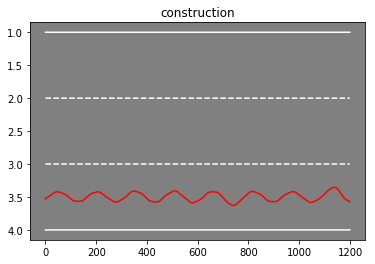

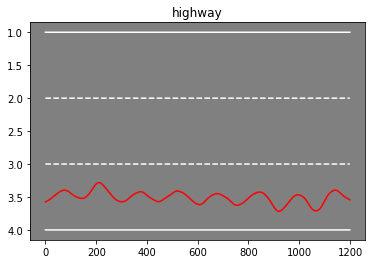

In [17]:

# random participant
s = rd.randrange(len(subj))
name = subj[s]
dat = data[name]
lanepos = np.array(dat['lanepos'].astype(float))

start, stop, condition = create_blocks(dat)

# random block
i = rd.randrange(len(subj) - 1) if len(subj) > 1 else 1
high_ex = pd.DataFrame(
    {
        'start': start[i],
        'stop': stop[i],
        'condition': condition[i]
    }, index=[i])
con_ex = pd.DataFrame(
    {
        'start': start[i + 1],
        'stop': stop[i + 1],
        'condition': condition[i + 1]
    },
    index=[i + 1])
condition = [high_ex, con_ex]

# random segment, blocks are fairly long, so extract a random 60s segment
seglen = int(60/srate)

fig = plt.figure()
for i, con in enumerate(condition):
    start, = con['start']
    stop, = con['stop']
    block = np.array(lanepos[start:stop])

    start = rd.randrange(0, len(block) - seglen)
    stop = start + seglen

    for j in range(1, 5):
        lane = np.empty([len(block)])
        lane[:] = j
        if j == 1 or j == 4:
            plt.plot(lane[start:stop], color='white')
        else:
            plt.plot(lane[start:stop], color='white', linestyle='dashed')

    title, = con['condition']
    plt.title(title)
    plt.plot(block[start:stop], color='red')
    ax = plt.gca()
    ax.set_facecolor('grey')
    plt.gca().invert_yaxis()
    plt.show()

In [18]:

nback = find_nback(filename[1])[0]
nbacklevel = int(re.search(r'\d+', nback).group())
noSign = 20*20  # no of samples in build up phase
errors = []
error_rates = []
for s, name in enumerate(subj):

    dat = data[name]
    start, stop, condition = create_blocks(dat)
    speedlimit = np.array(dat['currentspeed'].astype(int))
    imagined_limit = np.array(dat['imaginedSpeedlimit'].astype(int))
    new_signs = np.where(np.diff(speedlimit))[0] + 1
    # alternative: new_signs = np.where(speedlimit[1:] != speedlimit[:-1])[0] + 1

    nbackspeed = np.zeros_like(speedlimit)
    # build-up phase
    nbackspeed[0:new_signs[0]] = 60
    for i in range(0, nbacklevel):
        nbackspeed[new_signs[i]:new_signs[i + 1]] = speedlimit[new_signs[i]]

    # nback phase
    for i in range(nbacklevel, len(new_signs)):
        start = new_signs[i]
        stop = new_signs[i + 1] if i != len(new_signs) - 1 else len(nbackspeed)
        nbackspeed[start:stop] = speedlimit[new_signs[i - nbacklevel]]

    # # of errors
    n_error = 0
    for i in range(nbacklevel + 2, len(new_signs)):
        pos = new_signs[i] - 1
        if(imagined_limit[pos] != nbackspeed[pos]):
            n_error += 1
    error_rates.append(n_error/len(new_signs - nbacklevel))
    errors.append(n_error)

avg_error_rate = sum(error_rates)/len(error_rates)
avg_error = sum(errors)/len(errors)
print('The average speed regulation error rate for Nback',
      nbacklevel, 'is', avg_error_rate)


The average speed regulation error rate for Nback 2 is 0.029299450549450552


In [ ]:
# overtaking distance

for s, name in enumerate(subj):

    dat = data[name]
    start, stop, condition = create_blocks(dat)
